<style>
@media print
{
h2 {page-break-before:always}
}
</style>

# Homework 06

### Brown University  
### DATA 1010  
### Fall 2019

## Problem 1

Generate a random $n \times d$ feature matrix `X`, and then change its last column so as to induce an approximate (but not exact) linear dependence relationship involving all of the last three columns. Then define the response vector `y` to be an approximate linear combination of the first two columns. 

Let $d = 10$, and explore the behavior of the coefficient vector `X \ y` for various values of $n$ (including ones less than $d$, equal to $d$ and greater than $d$). Show how lasso and ridge regression mitigate the problems you observe.

Hint: make bar plots of the coefficients you obtain, following the example in [Data Gymnasia](https://mathigon.org/course/machine-learning/a-regression-example-linear-models). 

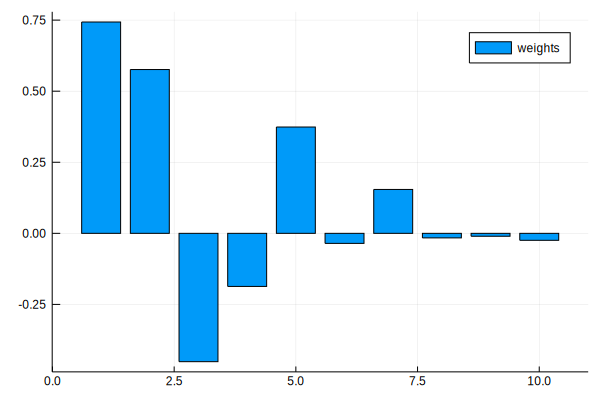

In [1]:
n = 5
d = 10
X = randn(n,10)
X[:,10] = X[:,9] + X[:,8] + 0.01randn(n)
y = X[:,1] + X[:,2] + 0.1randn(n);
bar(X \ y, label = "weights")

## Problem 2

Suppose that for each $i = 1,2,\ldots, n$, the random vector $\mathbf{X}_i$ is chosen from a distribution on $\mathbb{R}^p$ and then $Y_i$ is chosen from the Bernoulli distribution with probability $r(\mathbf{X}_i)$, where $r: \mathbb{R}^p \to [0,1]$ is some function.

(a) Given $\mathbf{y} \in \{0,1\}^n$, find $\mathbb{P}( (Y_1, \ldots, Y_n) =
    \mathbf{y} | \mathbf{X}_1, \mathbf{X}_2, \ldots, \mathbf{X}_n)$.

(b) Suppose that multiple candidate $r$'s are proposed. Show that
    finding the one which maximizes your answer to (a) is the same as
    finding the one that minimizes
    $$\sum_{i=1}^{n} \left[y_i \log \frac{1}{r(X_i)} +(1-y_i)\log\frac{1}{1-r(X_i)}\right]$$


(a) For each $i$, the conditional probability given $\mathbf{X}_i$
    of the event $\{Y_i = y_i\}$ is equal to $r(\mathbf{X}_i)$ if
    $y_i = 1$ or $1 - r(\mathbf{X}_i)$ if $y_i = 0$. Therefore,
    $$\mathbb{P}( (Y_1, \ldots, Y_n) =
      \mathbf{y} | \mathbf{X}_1, \mathbf{X}_2, \ldots, \mathbf{X}_n) =
      \prod_{y_i = 1}r(\mathbf{X}_i) \prod_{_i =
        0}(1-r(\mathbf{X}_i))$$

(b) Minimizing a quantity is the same as minimizing its logarithm,
    so we can replace the conditional probability above with
    $$\sum_{y_i = 1}\log r(\mathbf{X}_i) +
      \sum_{y_i = 0} \log (1-r(\mathbf{X}_i))$$
   without changing the argmax. We can multiply all the terms in the first sum by $y_i$ and in the second by $1-y_i$ so that both sums
    can be written over all $i$ values. Multiplying by $-1$ to change
    the maximization problem to a minimization problem yields
    $$\sum_{i=1}^{n} \left[y_i \log \frac{1}{r(X_i)} +
        (1-y_i)\log\frac{1}{1-r(X_i)}\right],$$
   as desired. 

## Problem 3

Train a QDA classifier for identifying a car as American or Japanese based on its weight and MPG rating. Use the `cars` dataset from the `VegaDatasets` package. Show the classification regions in different colors.   

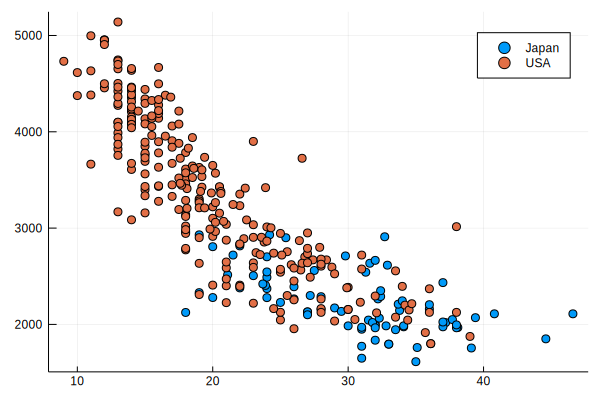

In [2]:
using VegaDatasets, Plots, DataFrames
D = DataFrame(dataset("cars"))
cars = [((x,y),c) for (x,y,c) in zip(D[:,:Miles_per_Gallon],
                                     D[:,:Weight_in_lbs],
                                     D[:,:Origin]) 
           if !any(ismissing.([x,y,c])) && c ≠ "Europe"]
x₁s = [x₁ for ((x₁,x₂),y) in cars]
x₂s = [x₂ for ((x₁,x₂),y) in cars]
ys = [y for ((x₁,x₂),y) in cars]
scatter(x₁s,x₂s,group=ys)


We follow the flowers example from Data Gymnasia. 

In [ ]:
using Plots, StatsBase, LinearAlgebra
gr(match_dimensions=true,size=(350,440))
struct Normal
    μ::Vector
    Σ::Array
end
f(x,N::Normal) = 1/(2π*sqrt(det(N.Σ))) * exp(-1/2*((x-N.μ)'*inv(N.Σ)*(x-N.μ)))
function mvn_estimate(cars,country)
    cars_subset = [[x₁,x₂] for ((x₁,x₂),y) in cars if y == country]
    m̂ = mean(cars_subset)
    Ŝ = mean([(X - m̂)*(X - m̂)' for X in cars_subset])
    Normal(m̂,Ŝ)
end

Next we define a function to compute the classifications and a function to plot them.
      
<img src="cars-QDA.png" alt="QDA" width="300" align=right>
    
```julia
classify(x,ps,Ns) = argmax([p*f(x,N) for (p,N) in zip(ps,Ns)])
xgrid = range(0,stop=50,length=256)
ygrid = range(1000,stop=5500,length=256)        
function classificationplot(cars,ps,Ns)
    P = heatmap(xgrid,
                ygrid,
                [classify([x,y],ps,Ns) for x=xgrid,y=ygrid],
                fillcolor=cgrad([:green,:red]),
                opacity=0.4)
    scatter!(P,[(x₁,x₂) for ((x₁,x₂),y) in cars],
             group=ys,
             markersize=2)
    P
end
countries = ["USA","Japan"]
countrycounts = countmap([y for ((x₁,x₂),y) in cars])
p̂s = [countrycounts[y]/length(cars) for y in countries]
N̂s = [mvn_estimate(cars,y) for y in countries]
classificationplot(cars,p̂s,N̂s)
```

## Problem 4

Train a classifier based on kernel density estimation for identifying a car as American or Japanese based on its weight and MPG rating. Use the `cars` dataset from the `VegaDatasets` package. Show the classification regions in different colors.   

Although the kernel density estimators can be fit using the code from class, for variety's sake, we will use a package in this solution. 

We begin by extracting the relevant columns from the data frame. 

In [3]:
using VegaDatasets, DataFrames, Plots
D = DataFrame(dataset("cars"))
x₁ = D[:, :Miles_per_Gallon]
x₂ = D[:, :Weight_in_lbs]
y = D[:, :Origin];

Next we discard missing data and subset on the `:Origin` column. 

In [4]:
data = map(identity, hcat([x for x in eachrow([x₁ x₂ y]) if !any(ismissing.(x))]...))
data = permutedims(data, (2,1))
usa = map(identity, data[data[:,3] .== "USA", 1:2])
japan = map(identity, data[data[:,3] .== "Japan", 1:2])
(a,b), (c,d) = extrema(data[:, 1:2], dims=1);

Now we use the `KernelDensity` package to fit kernel density estimators.

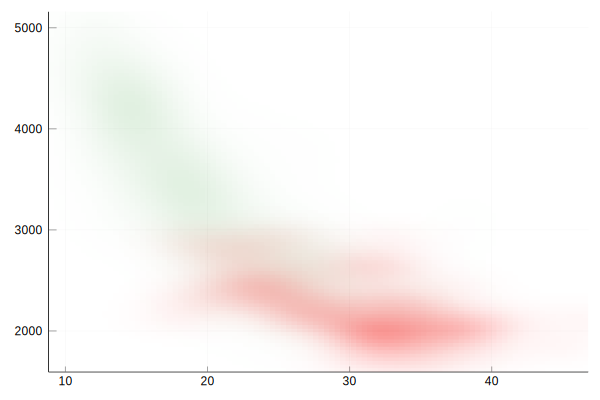

In [5]:
using KernelDensity
us_estimator = kde(usa)
japan_estimator = kde(japan)
heatmap(LinRange(a, b, 100), LinRange(c, d, 100), (x,y) -> pdf(us_estimator, x, y),
        fillcolor = cgrad([:white, :green]), fillopacity = 0.4, colorbar = false)
heatmap!(LinRange(a, b, 100), LinRange(c, d, 100), (x,y) -> pdf(japan_estimator, x, y),
        fillcolor = cgrad([:white, :red]), fillopacity = 0.4)

We can also visualize the classification function: 

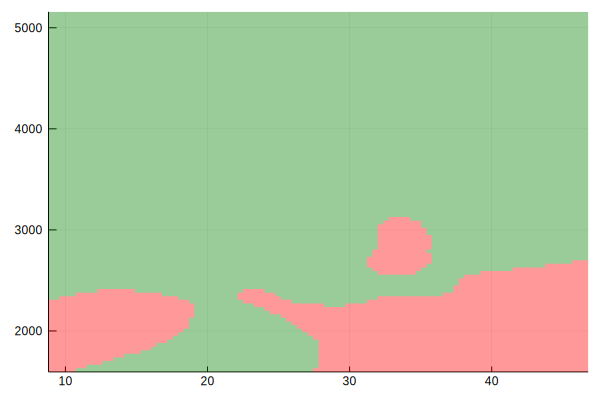

In [6]:
heatmap(LinRange(a, b, 100), LinRange(c, d, 100), 
        (x,y) -> size(japan, 1)*pdf(japan_estimator, x, y) > size(usa, 1) * pdf(us_estimator, x, y),
        fillcolor = cgrad([:green, :red]), fillopacity = 0.4, colorbar = false)

## Problem 5

(a) Serialize each of the first 1000 images in the MNIST data set and compute the pairwise Euclidean distances between the resulting vectors. Make a histogram of the resulting list of a million numbers. 

(b) Repeat the exercise from (a) with 1000 white-noise images (`rand(28,28)`). 

In [7]:
using JLD
images = load("mnist.jld")["images"]

28×28×1000 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.0      

In [8]:
using MLDatasets
features, labels = MNIST.traindata(Float64)
#save("mnist.jld", "images", features[:,:,1:1000])
features = permutedims(reshape(features, (28^2, 60_000)),(2,1))
distances = [norm(features[i,:] - features[j,:]) for i=1:10^3, j = 1:10^3]

1000×1000 Array{Float64,2}:
  0.0       9.36122  10.8751   10.0189   …  10.4126   10.1437   10.145  
  9.36122   0.0      11.3684   10.8491       8.93634   9.55577  11.0917 
 10.8751   11.3684    0.0      10.0847      10.6919   10.3429   10.0012 
 10.0189   10.8491   10.0847    0.0         10.7123    9.60721   8.75149
 10.4803   10.3672   10.053     9.36791     11.1926   11.0099   10.37   
 10.1266   10.5019   10.3301    9.90219  …   9.40895  10.6537    9.16678
  9.50428  11.1851   10.1611    9.23268     11.4766    9.56523   9.6553 
  8.50967  10.1871   10.3497   10.2143      10.5344   10.391    11.1015 
  9.31437  10.6597    9.38704   8.43996     10.7458    9.35525   9.15598
 10.0757   10.8737    8.514     9.40246      8.64157  10.8917    8.71817
  8.3915    9.96716  11.3765    9.80189  …  11.0898    8.56664   9.57628
 11.2449   10.9816    9.38212   7.51718     10.4831    9.56529   8.73093
 10.4553   11.8824   11.3417   11.1778      12.5855    9.21292  11.1961 
  ⋮                    

┌ Info: Recompiling stale cache file /Users/sswatson/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


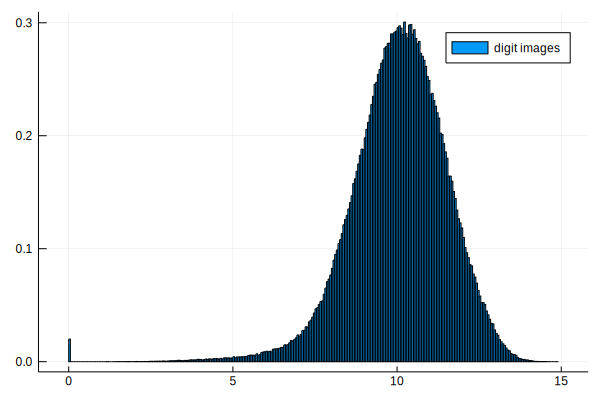

In [9]:
using Plots
histogram(distances[:], normed = true, label = "digit images")

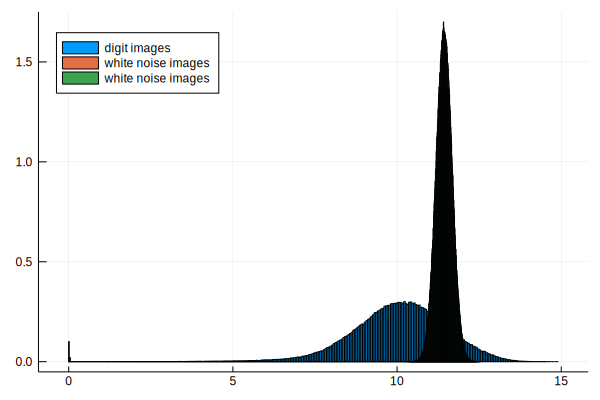

In [10]:
features = rand(1000, 28^2)
distances = [norm(features[i,:] - features[j,:]) for i=1:10^3, j = 1:10^3]
histogram!(distances[:], normed = true, label = "white noise images", legend = :topleft)